## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
from scipy.stats import zscore

sns.set()

from google.colab import drive
drive.mount('/content/drive')

# Add path to root directory with data
sys.path += ['/content/drive/My Drive/UCLA/Classes/Computer Science/CS145/Team 3 - Kaggle/Data']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

In [2]:
training_data = sys.path[-1] + '/train.csv'
graph_data =  sys.path[-1] + '/graph.csv'

# Import datasets
train = pd.read_csv(training_data)
graph = pd.read_csv(graph_data)

## EDA - Main Training Data

### General Dataset Information

- Province_State: Province, state or dependency name.
- Country_Region: Country, region or sovereignty name. The names of locations included on the Website correspond with the official designations used by the U.S. Department of State.
- Last Update: MM/DD/YYYY HH:mm:ss (24 hour format, in UTC).
- Lat and Long_: Dot locations on the dashboard. All points (except for Australia) shown on the map are based on geographic centroids, and are not representative of a specific address, building or any location at a spatial scale finer than a province/state. Australian dots are located at the centroid of the largest city in each state.
- Confirmed: Counts include confirmed and probable (where reported).
- Deaths: Counts include confirmed and probable (where reported).
- Recovered: Recovered cases are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number. US state-level recovered cases are from COVID Tracking Project.
- Active: Active cases = total cases - total recovered - total deaths.
- Incidence_Rate: Incidence Rate = cases per 100,000 persons.
- Case-Fatality Ratio (%): Case-Fatality Ratio (%) = Number recorded deaths / Number cases.
All cases, deaths, and recoveries reported are based on the date of initial report. Exceptions to this are noted in the "Data Modification" and "Retrospective reporting of (probable) cases and deaths" subsections below.

In [3]:
train.info()

'''
Based on this info, it seems like Recovered, People Hospitalized and
Hospitalization Rate have NaN/Null values that we need to deal with. 
Some options to do this:
1. Remove those rows of data entirely
2. Replace the value with the mean 
  - Last 7 day mean
  - Mean across the entire duration
3. Replace value with median value
4. Trivially set it to 0
5. Build a model to predict the missing values (LOL)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7100 non-null   int64  
 1   Province_State        7100 non-null   object 
 2   Date                  7100 non-null   object 
 3   Confirmed             7100 non-null   int64  
 4   Deaths                7100 non-null   int64  
 5   Recovered             5771 non-null   float64
 6   Active                7100 non-null   float64
 7   Incident_Rate         7100 non-null   float64
 8   People_Tested         7100 non-null   float64
 9   People_Hospitalized   5047 non-null   float64
 10  Mortality_Rate        7100 non-null   float64
 11  Testing_Rate          7100 non-null   float64
 12  Hospitalization_Rate  5047 non-null   float64
dtypes: float64(8), int64(3), object(2)
memory usage: 721.2+ KB


'\nBased on this info, it seems like Recovered, People Hospitalized and\nHospitalization Rate have NaN/Null values that we need to deal with. \nSome options to do this:\n1. Remove those rows of data entirely\n2. Replace the value with the mean \n  - Last 7 day mean\n  - Mean across the entire duration\n3. Replace value with median value\n4. Trivially set it to 0\n5. Build a model to predict the missing values (LOL)\n'

In [4]:
train.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2,2,Arizona,04-12-2020,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
3,3,Arkansas,04-12-2020,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


In [5]:
# General statistics about the main training dataset. 
train.describe()

'''
Because of the large variation in ranges of the variables, it's pretty important
that we perform some sort of Z-score normalization. The good thing is that except
for Provice State, all of our features are continuous. We don't have categorical data :)
'''

"\nBecause of the large variation in ranges of the variables, it's pretty important\nthat we perform some sort of Z-score normalization. The good thing is that except\nfor Provice State, all of our features are continuous. We don't have categorical data :)\n"

In [6]:
# Drop Id row because it has 7100 unique values, the same as the number of rows in the dataset
train.drop(['ID'], inplace=True, axis=1)

In [7]:
# Correlation of every feature with every other feature
train.corr()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Confirmed,1.000000,0.763886,0.769516,0.919093,0.626603,0.906105,0.872062,0.134176,0.410056,0.105496
Deaths,0.763886,1.000000,0.414893,0.687528,0.536329,0.674389,0.964737,0.492999,0.345898,0.298620
Recovered,0.769516,0.414893,1.000000,0.384873,0.471676,0.694943,0.557223,0.076538,0.316798,-0.020390
Active,0.919093,0.687528,0.384873,1.000000,0.523298,0.858354,0.804527,0.109076,0.324393,0.117458
Incident_Rate,0.626603,0.536329,0.471676,0.523298,1.000000,0.511856,0.553097,0.099195,0.721931,-0.141592
People_Tested,0.906105,0.674389,0.694943,0.858354,0.511856,1.000000,0.821799,0.080157,0.497311,0.096117
People_Hospitalized,0.872062,0.964737,0.557223,0.804527,0.553097,0.821799,1.000000,0.434983,0.379084,0.325941
Mortality_Rate,0.134176,0.492999,0.076538,0.109076,0.099195,0.080157,0.434983,1.000000,-0.060319,0.636383
Testing_Rate,0.410056,0.345898,0.316798,0.324393,0.721931,0.497311,0.379084,-0.060319,1.000000,-0.222234
Hospitalization_Rate,0.105496,0.298620,-0.020390,0.117458,-0.141592,0.096117,0.325941,0.636383,-0.222234,1.000000


In [8]:
# Exploring just the correlation with our target variable
train.corr()['Confirmed'].sort_values(ascending=False)

'''
Correlations intuitively make sense. The number of confirmed cases
is obviously related to the current number of active cases. The higher
the number of people hospitalized and tested, the greater the number
of cases (which also makes sense). 

I find it interesting that confirmed cases and recovered are so highly
correlated. My guess is that recovered is probably negatively correlated
with active cases rather than confirmed cases.
'''

'\nCorrelations intuitively make sense. The number of confirmed cases\nis obviously related to the current number of active cases. The higher\nthe number of people hospitalized and tested, the greater the number\nof cases (which also makes sense). \n\nI find it interesting that confirmed cases and recovered are so highly\ncorrelated. My guess is that recovered is probably negatively correlated\nwith active cases rather than confirmed cases.\n'

'\nInteresting how the top left has strong positive correlation, while the\nthe feature surrounding the first 6 or 7 features all show some form of\nnegative correlation. \n'

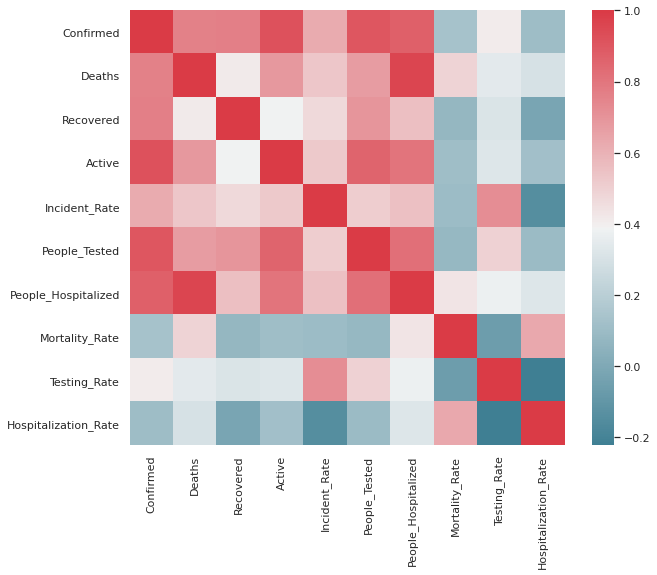

In [9]:
# Visualizing correlation matrix
figure, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, 
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, 
            ax=ax)

'''
Interesting how the top left has strong positive correlation, while the
the feature surrounding the first 6 or 7 features all show some form of
negative correlation. 
'''

In [10]:
train.groupby(['Province_State'], axis=0).count()[:20] # -> 142 days worth of training data :)

,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Province_State,,,,,,,,,,,
Alabama,142,142,142,107,142,142,142,138,142,142,138
Alaska,142,142,142,142,142,142,142,17,142,142,17
Arizona,142,142,142,140,142,142,142,137,142,142,137
Arkansas,142,142,142,142,142,142,142,137,142,142,137
California,142,142,142,5,142,142,142,16,142,142,16
Colorado,142,142,142,129,142,142,142,138,142,142,138
Connecticut,142,142,142,124,142,142,142,135,142,142,135
Delaware,142,142,142,142,142,142,142,16,142,142,16
Florida,142,142,142,5,142,142,142,138,142,142,138


In [11]:
print("Start Date:", train['Date'].min())
print("End Date:", train['Date'].max())

Start Date: 04-12-2020
End Date: 08-31-2020


## EDA - Graph Mobility Data

In [12]:
graph.shape # :o 144 columns

(2500, 144)

In [13]:
graph.info() # assuming 142/144 columns correspond to each unique date in the training dataset per state

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 144 entries, source_state to 08-31-2020
dtypes: float64(142), object(2)
memory usage: 2.7+ MB


In [14]:
'''
Do we want to do row wise Z-score normalization? I don't see how column wise normalization would
make sense since it would skew the lower and upper bound values pretty significantly
'''

graph.head(5)

,source_state,target_state,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,04-22-2020,04-23-2020,04-24-2020,04-25-2020,04-26-2020,04-27-2020,04-28-2020,04-29-2020,04-30-2020,05-01-2020,05-02-2020,05-03-2020,05-04-2020,05-05-2020,05-06-2020,05-07-2020,05-08-2020,05-09-2020,05-10-2020,05-11-2020,05-12-2020,05-13-2020,05-14-2020,05-15-2020,05-16-2020,05-17-2020,05-18-2020,05-19-2020,...,07-23-2020,07-24-2020,07-25-2020,07-26-2020,07-27-2020,07-28-2020,07-29-2020,07-30-2020,07-31-2020,08-01-2020,08-02-2020,08-03-2020,08-04-2020,08-05-2020,08-06-2020,08-07-2020,08-08-2020,08-09-2020,08-10-2020,08-11-2020,08-12-2020,08-13-2020,08-14-2020,08-15-2020,08-16-2020,08-17-2020,08-18-2020,08-19-2020,08-20-2020,08-21-2020,08-22-2020,08-23-2020,08-24-2020,08-25-2020,08-26-2020,08-27-2020,08-28-2020,08-29-2020,08-30-2020,08-31-2020
0,Alabama,Alabama,616434.0,784114.0,756555.0,786938.0,792072.0,846587.0,783567.0,619458.0,804750.0,834554.0,838235.0,778664.0,892777.0,807204.0,719330.0,810521.0,822406.0,778034.0,850735.0,1010272.0,923634.0,784951.0,905175.0,910712.0,924559.0,941686.0,937247.0,949545.0,840018.0,904659.0,926422.0,936204.0,938898.0,995656.0,935413.0,842304.0,949670.0,965552.0,...,998595.0,1044361.0,957974.0,868476.0,958775.0,991009.0,1018993.0,1039742.0,1072121.0,1012733.0,928111.0,1025015.0,1040122.0,1047277.0,1057097.0,1106791.0,999707.0,884354.0,1022000.0,1027038.0,1016262.0,1056928.0,1096986.0,1008499.0,932255.0,1017359.0,1049739.0,1022899.0,1037504.0,1096001.0,988618.0,873985.0,950066.0,952730.0,961319.0,994395.0,993710.0,951297.0,826922.0,991456.0
1,Alabama,Alaska,16.0,8.0,13.0,12.0,9.0,10.0,10.0,11.0,8.0,12.0,8.0,17.0,17.0,8.0,11.0,10.0,12.0,9.0,17.0,14.0,12.0,11.0,8.0,10.0,12.0,10.0,10.0,9.0,8.0,6.0,6.0,7.0,6.0,13.0,13.0,9.0,13.0,13.0,...,66.0,64.0,49.0,64.0,70.0,61.0,56.0,65.0,90.0,57.0,68.0,80.0,76.0,63.0,96.0,81.0,74.0,71.0,70.0,60.0,46.0,58.0,77.0,67.0,61.0,56.0,50.0,57.0,63.0,55.0,54.0,48.0,30.0,44.0,37.0,50.0,42.0,44.0,45.0,50.0
2,Alabama,Arizona,158.0,176.0,148.0,158.0,140.0,176.0,170.0,155.0,166.0,187.0,224.0,222.0,190.0,169.0,152.0,166.0,152.0,169.0,191.0,149.0,149.0,144.0,182.0,176.0,173.0,163.0,145.0,172.0,187.0,177.0,198.0,178.0,178.0,212.0,201.0,221.0,240.0,227.0,...,282.0,332.0,306.0,305.0,285.0,270.0,267.0,235.0,261.0,222.0,240.0,273.0,273.0,270.0,261.0,320.0,271.0,251.0,255.0,200.0,260.0,204.0,210.0,217.0,228.0,273.0,261.0,292.0,317.0,265.0,236.0,230.0,220.0,211.0,226.0,220.0,216.0,212.0,179.0,213.0
3,Alabama,Arkansas,298.0,399.0,370.0,401.0,649.0,683.0,650.0,412.0,482.0,487.0,432.0,482.0,467.0,395.0,378.0,472.0,481.0,480.0,506.0,508.0,536.0,382.0,484.0,507.0,481.0,451.0,521.0,448.0,307.0,427.0,541.0,496.0,557.0,535.0,475.0,421.0,472.0,578.0,...,803.0,893.0,864.0,711.0,697.0,691.0,675.0,815.0,778.0,683.0,618.0,616.0,673.0,690.0,768.0,742.0,740.0,692.0,637.0,694.0,690.0,767.0,825.0,780.0,641.0,657.0,673.0,722.0,793.0,730.0,772.0,647.0,622.0,738.0,683.0,660.0,686.0,751.0,698.0,585.0
4,Alabama,California,358.0,421.0,421.0,369.0,341.0,380.0,330.0,367.0,473.0,436.0,441.0,437.0,448.0,491.0,461.0,469.0,457.0,472.0,434.0,239.0,247.0,210.0,375.0,384.0,280.0,303.0,316.0,303.0,252.0,303.0,318.0,331.0,348.0,378.0,319.0,370.0,405.0,361.0,...,653.0,645.0,671.0,596.0,656.0,642.0,680.0,718.0,694.0,526.0,538.0,657.0,615.0,593.0,650.0,673.0,673.0,666.0,717.0,613.0,646.0,661.0,642.0,610.0,597.0,603.0,655.0,585.0,628.0,682.0,609.0,564.0,572.0,569.0,592.0,610.0,573.0,697.0,638.0,638.0


In [15]:
graph.describe()

,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,04-22-2020,04-23-2020,04-24-2020,04-25-2020,04-26-2020,04-27-2020,04-28-2020,04-29-2020,04-30-2020,05-01-2020,05-02-2020,05-03-2020,05-04-2020,05-05-2020,05-06-2020,05-07-2020,05-08-2020,05-09-2020,05-10-2020,05-11-2020,05-12-2020,05-13-2020,05-14-2020,05-15-2020,05-16-2020,05-17-2020,05-18-2020,05-19-2020,05-20-2020,05-21-2020,...,07-23-2020,07-24-2020,07-25-2020,07-26-2020,07-27-2020,07-28-2020,07-29-2020,07-30-2020,07-31-2020,08-01-2020,08-02-2020,08-03-2020,08-04-2020,08-05-2020,08-06-2020,08-07-2020,08-08-2020,08-09-2020,08-10-2020,08-11-2020,08-12-2020,08-13-2020,08-14-2020,08-15-2020,08-16-2020,08-17-2020,08-18-2020,08-19-2020,08-20-2020,08-21-2020,08-22-2020,08-23-2020,08-24-2020,08-25-2020,08-26-2020,08-27-2020,08-28-2020,08-29-2020,08-30-2020,08-31-2020
count,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,...,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2500.000,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03
mean,1.031167e+04,1.170723e+04,1.151140e+04,1.178438e+04,1.179731e+04,1.230519e+04,1.163154e+04,1.057303e+04,1.205244e+04,1.279990e+04,1.289487e+04,1.279506e+04,1.316893e+04,1.259060e+04,1.127088e+04,1.250965e+04,1.274783e+04,1.249942e+04,1.273562e+04,1.481305e+04,1.410618e+04,1.189527e+04,1.357602e+04,1.371063e+04,1.400098e+04,1.426416e+04,1.431527e+04,1.451098e+04,1.305908e+04,1.341780e+04,1.388229e+04,1.402090e+04,1.394716e+04,1.493916e+04,1.440792e+04,1.345289e+04,1.450240e+04,1.453921e+04,1.508014e+04,1.555555e+04,...,1.624098e+04,1.700677e+04,1.615407e+04,1.475037e+04,1.552673e+04,1.643263e+04,17121.944,1.720143e+04,1.749796e+04,1.696104e+04,1.606001e+04,1.681209e+04,1.681747e+04,1.716191e+04,1.728122e+04,1.798962e+04,1.676487e+04,1.490500e+04,1.678955e+04,1.694612e+04,1.649601e+04,1.733355e+04,1.781142e+04,1.683271e+04,1.591924e+04,1.672395e+04,1.734608e+04,1.666848e+04,1.694528e+04,1.718320e+04,1.619850e+04,1.453065e+04,1.511724e+04,1.529283e+04,1.535136e+04,1.538828e+04,1.577180e+04,1.530974e+04,1.397103e+04,1.609596e+04
std,1.034501e+05,1.168826e+05,1.139024e+05,1.167934e+05,1.169899e+05,1.218210e+05,1.149333e+05,1.045124e+05,1.190462e+05,1.268384e+05,1.275786e+05,1.275655e+05,1.309348e+05,1.248459e+05,1.118748e+05,1.237415e+05,1.259289e+05,1.238079e+05,1.262020e+05,1.473292e+05,1.395072e+05,1.178829e+05,1.346874e+05,1.365075e+05,1.393648e+05,1.415439e+05,1.431302e+05,1.446164e+05,1.293749e+05,1.335264e+05,1.377670e+05,1.390604e+05,1.376357e+05,1.470264e+05,1.406257e+05,1.333435e+05,1.435389e+05,1.442478e+05,1.492994e+05,1.532019e+05,...,1.552949e+05,1.622360e+05,1.522990e+05,1.395964e+05,1.487638e+05,1.573289e+05,163795.186,1.647693e+05,1.671476e+05,1.613597e+05,1.526317e+05,1.613594e+05,1.625385e+05,1.650735e+05,1.660596e+05,1.726333e+05,1.604382e+05,1.424658e+05,1.617607e+05,1.635318e+05,1.588207e+05,1.664140e+05,1.705959e+05,1.611457e+05,1.524941e+05,1.610863e+05,1.670902e+05,1.602729e+05,1.624529e+05,1.646748e+05,1.551829e+05,1.396637e+05,1.461652e+05,1.485194e+05,1.481988e+05,1.482535e+05,1.517399e+05,1.477725e+05,1.3

## Data Processing

#### Create training data sorted by state and date. (Ideally want to eventually perform z-score normalization on a state by state basis, and fill in NaN values based on mean values per state)

In [16]:
# Get all state names
state_names = train['Province_State'].unique()

# Group training data by state names
group_by_state = train.groupby(train.Province_State)

# Create training data sorted by state and date
training_grouped_by_state = pd.DataFrame()
for state in state_names:
  state_specific_df = pd.DataFrame(group_by_state.get_group(state))
  training_grouped_by_state = training_grouped_by_state.append(state_specific_df)

# Reset index since group by creates incorrect indexes
training_grouped_by_state = training_grouped_by_state.reset_index(drop=True)

training_grouped_by_state.head()

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,Alabama,04-13-2020,3734,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886
2,Alabama,04-14-2020,3953,114,NaN,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541
3,Alabama,04-15-2020,4075,118,NaN,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436
4,Alabama,04-16-2020,4345,133,NaN,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273


### Merge Datasets

In [17]:
# Create a new column for each state in the dataset
for state in state_names:
  training_grouped_by_state[state] = 0

print("New number of columns:", training_grouped_by_state.shape[1])

training_grouped_by_state.head(3)

New number of columns: 62


,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alabama,04-13-2020,3734,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alabama,04-14-2020,3953,114,NaN,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
graph.head()

,source_state,target_state,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,04-22-2020,04-23-2020,04-24-2020,04-25-2020,04-26-2020,04-27-2020,04-28-2020,04-29-2020,04-30-2020,05-01-2020,05-02-2020,05-03-2020,05-04-2020,05-05-2020,05-06-2020,05-07-2020,05-08-2020,05-09-2020,05-10-2020,05-11-2020,05-12-2020,05-13-2020,05-14-2020,05-15-2020,05-16-2020,05-17-2020,05-18-2020,05-19-2020,...,07-23-2020,07-24-2020,07-25-2020,07-26-2020,07-27-2020,07-28-2020,07-29-2020,07-30-2020,07-31-2020,08-01-2020,08-02-2020,08-03-2020,08-04-2020,08-05-2020,08-06-2020,08-07-2020,08-08-2020,08-09-2020,08-10-2020,08-11-2020,08-12-2020,08-13-2020,08-14-2020,08-15-2020,08-16-2020,08-17-2020,08-18-2020,08-19-2020,08-20-2020,08-21-2020,08-22-2020,08-23-2020,08-24-2020,08-25-2020,08-26-2020,08-27-2020,08-28-2020,08-29-2020,08-30-2020,08-31-2020
0,Alabama,Alabama,616434.0,784114.0,756555.0,786938.0,792072.0,846587.0,783567.0,619458.0,804750.0,834554.0,838235.0,778664.0,892777.0,807204.0,719330.0,810521.0,822406.0,778034.0,850735.0,1010272.0,923634.0,784951.0,905175.0,910712.0,924559.0,941686.0,937247.0,949545.0,840018.0,904659.0,926422.0,936204.0,938898.0,995656.0,935413.0,842304.0,949670.0,965552.0,...,998595.0,1044361.0,957974.0,868476.0,958775.0,991009.0,1018993.0,1039742.0,1072121.0,1012733.0,928111.0,1025015.0,1040122.0,1047277.0,1057097.0,1106791.0,999707.0,884354.0,1022000.0,1027038.0,1016262.0,1056928.0,1096986.0,1008499.0,932255.0,1017359.0,1049739.0,1022899.0,1037504.0,1096001.0,988618.0,873985.0,950066.0,952730.0,961319.0,994395.0,993710.0,951297.0,826922.0,991456.0
1,Alabama,Alaska,16.0,8.0,13.0,12.0,9.0,10.0,10.0,11.0,8.0,12.0,8.0,17.0,17.0,8.0,11.0,10.0,12.0,9.0,17.0,14.0,12.0,11.0,8.0,10.0,12.0,10.0,10.0,9.0,8.0,6.0,6.0,7.0,6.0,13.0,13.0,9.0,13.0,13.0,...,66.0,64.0,49.0,64.0,70.0,61.0,56.0,65.0,90.0,57.0,68.0,80.0,76.0,63.0,96.0,81.0,74.0,71.0,70.0,60.0,46.0,58.0,77.0,67.0,61.0,56.0,50.0,57.0,63.0,55.0,54.0,48.0,30.0,44.0,37.0,50.0,42.0,44.0,45.0,50.0
2,Alabama,Arizona,158.0,176.0,148.0,158.0,140.0,176.0,170.0,155.0,166.0,187.0,224.0,222.0,190.0,169.0,152.0,166.0,152.0,169.0,191.0,149.0,149.0,144.0,182.0,176.0,173.0,163.0,145.0,172.0,187.0,177.0,198.0,178.0,178.0,212.0,201.0,221.0,240.0,227.0,...,282.0,332.0,306.0,305.0,285.0,270.0,267.0,235.0,261.0,222.0,240.0,273.0,273.0,270.0,261.0,320.0,271.0,251.0,255.0,200.0,260.0,204.0,210.0,217.0,228.0,273.0,261.0,292.0,317.0,265.0,236.0,230.0,220.0,211.0,226.0,220.0,216.0,212.0,179.0,213.0
3,Alabama,Arkansas,298.0,399.0,370.0,401.0,649.0,683.0,650.0,412.0,482.0,487.0,432.0,482.0,467.0,395.0,378.0,472.0,481.0,480.0,506.0,508.0,536.0,382.0,484.0,507.0,481.0,451.0,521.0,448.0,307.0,427.0,541.0,496.0,557.0,535.0,475.0,421.0,472.0,578.0,...,803.0,893.0,864.0,711.0,697.0,691.0,675.0,815.0,778.0,683.0,618.0,616.0,673.0,690.0,768.0,742.0,740.0,692.0,637.0,694.0,690.0,767.0,825.0,780.0,641.0,657.0,673.0,722.0,793.0,730.0,772.0,647.0,622.0,738.0,683.0,660.0,686.0,751.0,698.0,585.0
4,Alabama,California,358.0,421.0,421.0,369.0,341.0,380.0,330.0,367.0,473.0,436.0,441.0,437.0,448.0,491.0,461.0,469.0,457.0,472.0,434.0,239.0,247.0,210.0,375.0,384.0,280.0,303.0,316.0,303.0,252.0,303.0,318.0,331.0,348.0,378.0,319.0,370.0,405.0,361.0,...,653.0,645.0,671.0,596.0,656.0,642.0,680.0,718.0,694.0,526.0,538.0,657.0,615.0,593.0,650.0,673.0,673.0,666.0,717.0,613.0,646.0,661.0,642.0,610.0,597.0,603.0,655.0,585.0,628.0,682.0,609.0,564.0,572.0,569.0,592.0,610.0,573.0,697.0,638.0,638.0


In [19]:
# # Get list of all the dates
# all_dates = graph.columns[2:]

# # Initialize empty dataframe
# merged_df = pd.DataFrame()

# import time 

# start = time.time()

# # Try and merge these two dataframes together
# for source_state in state_names:
#   # Make sure source states are the same
#   state_train_data = training_grouped_by_state[training_grouped_by_state.Province_State == source_state]
#   state_graph_data = graph[graph.source_state == source_state]
#   # Loop through all the target_states and dates
#   for target_state in state_names:
#     for date in all_dates:
#       row = state_train_data[state_train_data.Date == date]
#       row_number = row.index[0]
#       # Update value
#       state_train_data.at[row_number, target_state] = state_graph_data[state_graph_data.target_state == target_state][date]
#   # Append data for this source state to the created dataframe
#   merged_df = merged_df.append(state_train_data)
#   print("Completed: ", source_state)

# end = time.time()

# print("Total merge time: ", end-start)

In [20]:
merged_df = pd.read_csv(sys.path[-1] + '/merged.csv')

In [21]:
merged_df.head(5)

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,4/12/20,3563,93,NaN,3470,75.988020,21583,437.0,2.610160,460.300152,12.264945,616434,16,158,298,358,102,27,24,3513,5877,16,48,572,350,148,105,443,639,12,97,67,346,167,2331,348,26,60,41,14,141,103,185,530,9,352,179,64,227,15,395,22,2390,1349,62,8,373,79,59,212,55
1,Alabama,4/13/20,3734,99,NaN,3635,79.634933,29182,457.0,2.651312,622.363852,12.238886,784114,8,176,399,421,147,47,17,5566,10273,14,50,686,432,196,103,563,927,18,124,74,351,193,4048,405,12,62,63,19,163,102,222,683,12,467,214,47,309,15,552,19,3641,1862,60,12,458,78,69,256,42
2,Alabama,4/14/20,3953,114,NaN,3839,84.305541,33117,493.0,2.883886,706.285508,12.471541,756555,13,148,370,421,125,56,9,5268,10806,12,32,656,455,154,221,607,1022,16,103,72,333,186,4071,465,20,70,36,13,151,101,231,831,15,464,200,42,331,31,527,18,3884,1598,78,13,469,88,96,256,60
3,Alabama,4/15/20,4075,118,NaN,3957,86.907433,34077,525.0,2.895706,726.759406,12.883436,786938,12,158,401,369,151,65,13,5429,10881,18,36,671,476,144,185,589,952,15,143,74,333,170,4424,452,24,63,46,14,158,86,237,750,24,447,225,41,315,31,513,18,4124,1489,79,12,490,79,92,229,50
4,Alabama,4/16/20,4345,133,NaN,4212,92.665716,36391,553.0,3.060990,776.110032,12.727273,792072,9,140,649,341,170,30,17,5532,10935,12,38,737,498,190,175,604,1004,18,127,83,345,159,4773,492,10,75,34,12,149,77,222,728,15,407,229,59,307,15,509,31,4172,1460,86,9,484,75,57,232,42


In [22]:
merged_df.shape

(7100, 62)

### Save merged dataframe

In [23]:
# merged_df.to_csv('merged.csv')
# !cp merged.csv "drive/My Drive/UCLA/Classes/Computer Science/CS145/Team 3 - Kaggle/Data/"

#### Fill NaN values with median of that column (again, just for now so we can train some sort of model, skipping so we can saw the raw merged data)

In [24]:
merged_df = merged_df.fillna(merged_df.mean())

In [25]:
merged_df.head()

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,4/12/20,3563,93,20422.274649,3470,75.988020,21583,437.0,2.610160,460.300152,12.264945,616434,16,158,298,358,102,27,24,3513,5877,16,48,572,350,148,105,443,639,12,97,67,346,167,2331,348,26,60,41,14,141,103,185,530,9,352,179,64,227,15,395,22,2390,1349,62,8,373,79,59,212,55
1,Alabama,4/13/20,3734,99,20422.274649,3635,79.634933,29182,457.0,2.651312,622.363852,12.238886,784114,8,176,399,421,147,47,17,5566,10273,14,50,686,432,196,103,563,927,18,124,74,351,193,4048,405,12,62,63,19,163,102,222,683,12,467,214,47,309,15,552,19,3641,1862,60,12,458,78,69,256,42
2,Alabama,4/14/20,3953,114,20422.274649,3839,84.305541,33117,493.0,2.883886,706.285508,12.471541,756555,13,148,370,421,125,56,9,5268,10806,12,32,656,455,154,221,607,1022,16,103,72,333,186,4071,465,20,70,36,13,151,101,231,831,15,464,200,42,331,31,527,18,3884,1598,78,13,469,88,96,256,60
3,Alabama,4/15/20,4075,118,20422.274649,3957,86.907433,34077,525.0,2.895706,726.759406,12.883436,786938,12,158,401,369,151,65,13,5429,10881,18,36,671,476,144,185,589,952,15,143,74,333,170,4424,452,24,63,46,14,158,86,237,750,24,447,225,41,315,31,513,18,4124,1489,79,12,490,79,92,229,50
4,Alabama,4/16/20,4345,133,20422.274649,4212,92.665716,36391,553.0,3.060990,776.110032,12.727273,792072,9,140,649,341,170,30,17,5532,10935,12,38,737,498,190,175,604,1004,18,127,83,345,159,4773,492,10,75,34,12,149,77,222,728,15,407,229,59,307,15,509,31,4172,1460,86,9,484,75,57,232,42


#### Z-Score Normalization

In [26]:
non_normalized_columns = merged_df[['Province_State', 'Date', 'Confirmed', 'Deaths']]
merged_df.drop(['Province_State','Date','Confirmed', 'Deaths'], inplace=True, axis=1)

In [27]:
merged_df_cols = merged_df.columns
normalized_data = zscore(merged_df)
merged_df = pd.DataFrame(data=normalized_data, columns=merged_df_cols)
merged_df.head()

,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0.0,-0.432133,-1.053241,-0.550898,-0.496762,-0.502952,-1.183415,0.015304,4.486602,-0.148913,-0.148362,-0.148679,-0.144376,-0.152378,-0.150690,-0.168636,-0.141176,-0.122772,-0.143270,-0.156821,-0.146354,-0.149412,-0.151557,-0.153261,-0.148685,-0.142866,-0.157159,-0.153141,-0.151201,-0.145168,-0.147731,-0.119787,-0.151327,-0.160105,-0.150688,-0.155811,-0.163677,-0.150592,-0.153530,-0.146984,-0.149041,-0.157773,-0.146989,-0.148681,-0.152896,-0.149260,-0.159944,-0.154567,-0.163427,-0.138974,-0.143413,-0.151545,-0.159349,-0.150143,-0.147525,-0.157744,-0.149387,-0.172053
1,0.0,-0.430046,-1.047519,-0.544158,-0.495052,-0.483109,-1.162581,0.009422,5.748461,-0.150109,-0.148167,-0.147234,-0.144220,-0.151769,-0.150204,-0.169199,-0.135539,-0.101796,-0.143386,-0.156735,-0.145780,-0.148731,-0.150782,-0.153296,-0.147140,-0.139867,-0.156766,-0.152766,-0.151098,-0.145136,-0.147419,-0.094958,-0.150866,-0.161238,-0.150636,-0.155254,-0.163377,-0.150412,-0.153575,-0.146817,-0.148191,-0.157523,-0.146430,-0.148308,-0.153241,-0.148762,-0.159944,-0.153028,-0.163644,-0.129728,-0.142501,-0.151591,-0.158625,-0.149407,-0.147536,-0.157361,-0.148895,-0.173849
2,0.0,-0.427466,-1.040191,-0.540668,-0.491976,-0.370966,-1.151793,0.061937,5.541068,-0.149362,-0.148470,-0.147649,-0.144220,-0.152067,-0.149986,-0.169843,-0.136357,-0.099253,-0.143503,-0.157506,-0.145931,-0.148539,-0.151460,-0.151212,-0.146574,-0.138878,-0.156897,-0.153058,-0.151127,-0.145250,-0.147503,-0.094625,-0.150381,-0.160590,-0.150427,-0.155938,-0.163737,-0.150510,-0.153619,-0.146776,-0.147369,-0.157272,-0.146445,-0.148457,-0.153342,-0.148628,-0.158536,-0.153273,-0.163717,-0.127932,-0.142971,-0.151175,-0.158444,-0.149312,-0.147422,-0.156327,-0.148895,-0.171363
3,0.0,-0.425974,-1.036108,-0.539817,-0.489241,-0.365267,-1.149161,0.154909,5.769713,-0.149511,-0.148362,-0.147206,-0.144348,-0.151715,-0.149767,-0.169521,-0.135915,-0.098895,-0.143153,-0.157335,-0.145856,-0.148365,-0.151621,-0.151848,-0.146806,-0.139607,-0.156962,-0.152503,-0.151098,-0.145250,-0.147695,-0.089521,-0.150486,-0.160267,-0.150610,-0.155685,-0.163677,-0.150453,-0.154287,-0.146749,-0.147819,-0.156521,-0.146527,-0.148191,-0.153362,-0.148726,-0.158536,-0.153410,-0.163717,-0.126158,-0.143164,-0.151152,-0.158625,-0.149131,-0.147525,-0.156480,-0.149197,-0.172744
4,0.0,-0.422748,-1.027074,-0.537764,-0.486849,-0.285570,-1.142817,0.119660,5.808348,-0.149960,-0.148557,-0.143658,-0.144417,-0.151459,-0.150617,-0.169199,-0.135632,-0.098637,-0.143503,-0.157249,-0.145523,-0.148182,-0.150879,-0.152024,-0.146613,-0.139066,-0.156766,-0.152725,-0.150965,-0.145174,-0.147827,-0.084474,-0.150163,-0.161399,-0.150296,-0.155989,-0.163797,-0.150526,-0.154688,-0.146817,-0.147941,-0.157272,-0.146722,-0.148149,-0.152998,-0.148774,-0.159944,-0.153449,-0.162774,-0.125803,-0.143216,-0.150991,-0.159168,-0.149182,-0.147570,-0.157820,-0.149163,-0.173849


In [28]:
merged_df['Province_State'] = non_normalized_columns['Province_State']
merged_df['Date'] = non_normalized_columns['Date']
merged_df['Confirmed'] = non_normalized_columns['Confirmed']
merged_df['Deaths'] = non_normalized_columns['Deaths']

# Re-ordering
merged_df_cols = merged_df.columns.tolist()
cols = merged_df_cols[-4:] + merged_df_cols[:len(merged_df_cols)-4]

merged_df = merged_df[cols]

print(merged_df.shape)

merged_df.head()

(7100, 62)


,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,4/12/20,3563,93,0.0,-0.432133,-1.053241,-0.550898,-0.496762,-0.502952,-1.183415,0.015304,4.486602,-0.148913,-0.148362,-0.148679,-0.144376,-0.152378,-0.150690,-0.168636,-0.141176,-0.122772,-0.143270,-0.156821,-0.146354,-0.149412,-0.151557,-0.153261,-0.148685,-0.142866,-0.157159,-0.153141,-0.151201,-0.145168,-0.147731,-0.119787,-0.151327,-0.160105,-0.150688,-0.155811,-0.163677,-0.150592,-0.153530,-0.146984,-0.149041,-0.157773,-0.146989,-0.148681,-0.152896,-0.149260,-0.159944,-0.154567,-0.163427,-0.138974,-0.143413,-0.151545,-0.159349,-0.150143,-0.147525,-0.157744,-0.149387,-0.172053
1,Alabama,4/13/20,3734,99,0.0,-0.430046,-1.047519,-0.544158,-0.495052,-0.483109,-1.162581,0.009422,5.748461,-0.150109,-0.148167,-0.147234,-0.144220,-0.151769,-0.150204,-0.169199,-0.135539,-0.101796,-0.143386,-0.156735,-0.145780,-0.148731,-0.150782,-0.153296,-0.147140,-0.139867,-0.156766,-0.152766,-0.151098,-0.145136,-0.147419,-0.094958,-0.150866,-0.161238,-0.150636,-0.155254,-0.163377,-0.150412,-0.153575,-0.146817,-0.148191,-0.157523,-0.146430,-0.148308,-0.153241,-0.148762,-0.159944,-0.153028,-0.163644,-0.129728,-0.142501,-0.151591,-0.158625,-0.149407,-0.147536,-0.157361,-0.148895,-0.173849
2,Alabama,4/14/20,3953,114,0.0,-0.427466,-1.040191,-0.540668,-0.491976,-0.370966,-1.151793,0.061937,5.541068,-0.149362,-0.148470,-0.147649,-0.144220,-0.152067,-0.149986,-0.169843,-0.136357,-0.099253,-0.143503,-0.157506,-0.145931,-0.148539,-0.151460,-0.151212,-0.146574,-0.138878,-0.156897,-0.153058,-0.151127,-0.145250,-0.147503,-0.094625,-0.150381,-0.160590,-0.150427,-0.155938,-0.163737,-0.150510,-0.153619,-0.146776,-0.147369,-0.157272,-0.146445,-0.148457,-0.153342,-0.148628,-0.158536,-0.153273,-0.163717,-0.127932,-0.142971,-0.151175,-0.158444,-0.149312,-0.147422,-0.156327,-0.148895,-0.171363
3,Alabama,4/15/20,4075,118,0.0,-0.425974,-1.036108,-0.539817,-0.489241,-0.365267,-1.149161,0.154909,5.769713,-0.149511,-0.148362,-0.147206,-0.144348,-0.151715,-0.149767,-0.169521,-0.135915,-0.098895,-0.143153,-0.157335,-0.145856,-0.148365,-0.151621,-0.151848,-0.146806,-0.139607,-0.156962,-0.152503,-0.151098,-0.145250,-0.147695,-0.089521,-0.150486,-0.160267,-0.150610,-0.155685,-0.163677,-0.150453,-0.154287,-0.146749,-0.147819,-0.156521,-0.146527,-0.148191,-0.153362,-0.148726,-0.158536,-0.153410,-0.163717,-0.126158,-0.143164,-0.151152,-0.158625,-0.149131,-0.147525,-0.156480,-0.149197,-0.172744
4,Alabama,4/16/20,4345,133,0.0,-0.422748,-1.027074,-0.537764,-0.486849,-0.285570,-1.142817,0.119660,5.808348,-0.149960,-0.148557,-0.143658,-0.144417,-0.151459,-0.150617,-0.169199,-0.135632,-0.098637,-0.143503,-0.157249,-0.145523,-0.148182,-0.150879,-0.152024,-0.146613,-0.139066,-0.156766,-0.152725,-0.150965,-0.145174,-0.147827,-0.084474,-0.150163,-0.161399,-0.150296,-0.155989,-0.163797,-0.150526,-0.154688,-0.146817,-0.147941,-0.157272,-0.146722,-0.148149,-0.152998,-0.148774,-0.159944,-0.153449,-0.162774,-0.125803,-0.143216,-0.150991,-0.159168,-0.149182,-0.147570,-0.157820,-0.149163,-0.173849


### Converting states to ints

In [29]:
state_to_number_map = dict()
number_to_state_map = dict()

unique_states = merged_df['Province_State'].unique()
for idx, state in enumerate(unique_states):
    state_to_number_map[state] = idx
    number_to_state_map[idx] = state

merged_df['Province_State'] = merged_df['Province_State'].map(lambda x: state_to_number_map[x])

### Create features from date

In [30]:
# merged_df[['Month','Day']] = 
dates = merged_df['Date'].apply(lambda x: x.split('/')[0:2])
merged_df['Month'] = [int(x[0]) for x in dates]
merged_df['Day'] = [int(x[1]) for x in dates]
merged_df.drop(['Date'], inplace=True, axis=1)
merged_df

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Month,Day
0,0,3563,93,0.000000,-0.432133,-1.053241,-0.550898,-4.967616e-01,-0.502952,-1.183415,1.530412e-02,4.486602,-0.148913,-0.148362,-0.148679,-0.144376,-0.152378,-0.150690,-0.168636,-0.141176,-0.122772,-0.143270,-0.156821,-0.146354,-0.149412,-0.151557,-0.153261,-0.148685,-0.142866,-0.157159,-0.153141,-0.151201,-0.145168,-0.147731,-0.119787,-0.151327,-0.160105,-0.150688,-0.155811,-0.163677,-0.150592,-0.153530,-0.146984,-0.149041,-0.157773,-0.146989,-0.148681,-0.152896,-0.149260,-0.159944,-0.154567,-0.163427,-0.138974,-0.143413,-0.151545,-0.159349,-0.150143,-0.147525,-0.157744,-0.149387,-0.172053,4,12
1,0,3734,99,0.000000,-0.430046,-1.047519,-0.544158,-4.950524e-01,-0.483109,-1.162581,9.422034e-03,5.748461,-0.150109,-0.148167,-0.147234,-0.144220,-0.151769,-0.150204,-0.169199,-0.135539,-0.101796,-0.143386,-0.156735,-0.145780,-0.148731,-0.150782,-0.153296,-0.147140,-0.139867,-0.156766,-0.152766,-0.151098,-0.145136,-0.147419,-0.094958,-0.150866,-0.161238,-0.150636,-0.155254,-0.163377,-0.150412,-0.153575,-0.146817,-0.148191,-0.157523,-0.146430,-0.148308,-0.153241,-0.148762,-0.159944,-0.153028,-0.163644,-0.129728,-0.142501,-0.151591,-0.158625,-0.149407,-0.147536,-0.157361,-0.148895,-0.173849,4,13
2,0,3953,114,0.000000,-0.427466,-1.040191,-0.540668,-4.919760e-01,-0.370966,-1.151793,6.193657e-02,5.541068,-0.149362,-0.148470,-0.147649,-0.144220,-0.152067,-0.149986,-0.169843,-0.136357,-0.099253,-0.143503,-0.157506,-0.145931,-0.148539,-0.151460,-0.151212,-0.146574,-0.138878,-0.156897,-0.153058,-0.151127,-0.145250,-0.147503,-0.094625,-0.150381,-0.160590,-0.150427,-0.155938,-0.163737,-0.150510,-0.153619,-0.146776,-0.147369,-0.157272,-0.146445,-0.148457,-0.153342,-0.148628,-0.158536,-0.153273,-0.163717,-0.127932,-0.142971,-0.151175,-0.158444,-0.149312,-0.147422,-0.156327,-0.148895,-0.171363,4,14
3,0,4075,118,0.000000,-0.425974,-1.036108,-0.539817,-4.892414e-01,-0.365267,-1.149161,1.549090e-01,5.769713,-0.149511,-0.148362,-0.147206,-0.144348,-0.151715,-0.149767,-0.169521,-0.135915,-0.098895,-0.143153,-0.157335,-0.145856,-0.148365,-0.151621,-0.151848,-0.146806,-0.139607,-0.156962,-0.152503,-0.151098,-0.145250,-0.147695,-0.089521,-0.150486,-0.160267,-0.150610,-0.155685,-0.163677,-0.150453,-0.154287,-0.146749,-0.147819,-0.156521,-0.146527,-0.148191,-0.153362,-0.148726,-0.158536,-0.153410,-0.163717,-0.126158,-0.143164,-0.151152,-0.158625,-0.149131,-0.147525,-0.156480,-0.149197,-0.172744,4,15
4,0,4345,133,0.000000,-0.422748,-1.027074,-0.537764,-4.868486e-01,-0.285570,-1.142817,1.196601e-01,5.808348,-0.149960,-0.148557,-0.143658,-0.144417,-0.151459,-0.150617,-0.169199,-0.135632,-0.098637,-0.143503,-0.157249,-0.145523,-0.148182,-0.150879,-0.152024,-0.146613,-0.139066,-0.156766,-0.152725,-0.150965,-0.145174,-0.147827,-0.084474,-0.150163,-0.161399,-0.150296,-0.155989,-0.163797,-0.150526,-0.154688,-0.146817,-0.147941,-0.157272,-0.146722,-0.148149,-0.152998,-0.148774,-0.159944,-0.153449,-0.162774,-0.125803,-0.143216,-0.150991,-0.159168,-0.149182,-0.147570,-0.157820,-0.149163,-0.173849,4,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7095,49,3733,37,-0.490539,-0.467979,-0.160465,-0.503936,-5.157329e-01,-1.283609,0.412880,-1.453110e+00

In [31]:
merged_df = merged_df[['Province_State','Month','Day','Confirmed','Deaths']]
merged_df

,Province_State,Month,Day,Confirmed,Deaths
0,0,4,12,3563,93
1,0,4,13,3734,99
2,0,4,14,3953,114
3,0,4,15,4075,118
4,0,4,16,4345,133
...,...,...,...,...,...
7095,49,8,27,3733,37
7096,49,8,28,3803,37
7097,49,8,29,3795,37
7098,49,8,30,3829,37


## Model Training (Linear Regression)

In [32]:
train = merged_df[['Province_State','Month','Day']]
confirmed = merged_df['Confirmed']
deaths = merged_df['Deaths']

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

dtr_confirmed = DecisionTreeRegressor(max_depth=15, criterion='mse', random_state=42)
dtr_confirmed.fit(train, confirmed)
pred_confirmed_train = dtr_confirmed.predict(train)
mae = mean_absolute_error(confirmed, pred_confirmed_train)
print("DTR Confirmed Train MAE: ", mae)

dtr_deaths = DecisionTreeRegressor(max_depth=15, criterion='mse', random_state=42)
dtr_deaths.fit(train, deaths)
pred_deaths_train = dtr_deaths.predict(train)
mae = mean_absolute_error(deaths, pred_deaths_train)
print("DTR Deaths Train MAE: ", mae)

DTR Confirmed Train MAE:  540.3012366906695
DTR Deaths Train MAE:  24.048135876737703


In [34]:
test_df = pd.read_csv(sys.path[-1] + '/test.csv')
test_df_dup = test_df.copy()

dates = test_df['Date'].apply(lambda x: x.split('-')[0:2])
test_df['Month'] = [int(x[0]) for x in dates]
test_df['Day'] = [int(x[1]) for x in dates]
test_df.drop(['Date'], inplace=True, axis=1)

test_df['Province_State'] = test_df['Province_State'].map(lambda x: state_to_number_map[x])

In [35]:
test_data = test_df[['Province_State','Month','Day']]

pred_confirmed = dtr_confirmed.predict(test_data)
pred_deaths = dtr_deaths.predict(test_data)

test_df['Confirmed'] = pred_confirmed
test_df['Deaths'] = pred_deaths

test_df.drop(['Province_State','Month','Day'], inplace=True, axis=1)

In [36]:
test_df

,ForecastID,Confirmed,Deaths
0,0,89349.0,1603.0
1,1,3136.0,24.0
2,2,177002.0,3747.0
3,3,43173.0,461.0
4,4,506613.0,9345.0
...,...,...,...
1295,1295,115448.0,2515.0
1296,1296,72161.0,1880.0
1297,1297,9588.5,190.0
1298,1298,71876.0,1100.0


In [37]:
#test_df.to_csv('predictions.csv', index=False)
#!cp predictions.csv "drive/My Drive/UCLA/Classes/Computer Science/CS145/Team 3 - Kaggle/Data/"

### Polynomial Regression

In [38]:
# normalized_train = zscore(train)

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model_1 = Pipeline([('poly', PolynomialFeatures(degree=7)),
                  ('linear', LinearRegression(fit_intercept=True))])

model_2 = Pipeline([('poly', PolynomialFeatures(degree=6)),
                  ('linear', LinearRegression(fit_intercept=True))])

model_confirmed = model_1.fit(train, confirmed)
model_deaths = model_2.fit(train, deaths)

pred_confirmed = model_confirmed.predict(test_data)
pred_deaths = model_deaths.predict(test_data)

test_df['Confirmed'] = pred_confirmed
test_df['Deaths'] = pred_deaths

test_df.head(20)

,ForecastID,Confirmed,Deaths
0,0,61017.730983,5027.489012
1,1,160061.272384,6735.194112
2,2,234783.417629,7849.447062
3,3,288867.930898,8482.210828
4,4,325742.008831,8732.737335
5,5,348559.445002,8688.370584
6,6,360189.127764,8425.329003
7,7,363208.498372,8009.467015
8,8,359901.596296,7497.015829
9,9,352261.318652,6935.303463


### Random Forest Regressor

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rfr_confirmed = RandomForestRegressor(n_estimators=100, max_depth=15, criterion='mse', random_state=42)
rfr_confirmed.fit(train, confirmed)
pred_confirmed_train = rfr_confirmed.predict(train)
mae = mean_absolute_error(confirmed, pred_confirmed_train)
print("RFR Confirmed Train MAE: ", mae)

rfr_deaths = RandomForestRegressor(n_estimators=100, max_depth=15, criterion='mse', random_state=42)
rfr_deaths.fit(train, deaths)
pred_deaths_train = rfr_deaths.predict(train)
mae = mean_absolute_error(deaths, pred_deaths_train)
print("RFR Deaths Train MAE: ", mae)

RFR Confirmed Train MAE:  559.1604278658837
RFR Deaths Train MAE:  18.645785870776777


In [41]:
pred_confirmed = rfr_confirmed.predict(test_data)
pred_deaths = rfr_deaths.predict(test_data)

test_df['Confirmed'] = pred_confirmed
test_df['Deaths'] = pred_deaths

In [42]:
test_df

,ForecastID,Confirmed,Deaths
0,0,90380.8100,1617.885119
1,1,3200.8600,24.218711
2,2,177660.5800,3769.631389
3,3,43565.4700,464.207143
4,4,509767.3800,9392.654000
...,...,...,...
1295,1295,115249.8800,2508.760000
1296,1296,72120.3770,1880.030000
1297,1297,9525.7465,190.490000
1298,1298,72149.0260,1099.160000


In [43]:
# test_df.to_csv('predictions2.csv', index=False)
# !cp predictions2.csv "drive/My Drive/UCLA/Classes/Computer Science/CS145/Team 3 - Kaggle/Data/"

### Different data processing strategy (One hot encoded state vector)

In [44]:
one_hot_vector = np.zeros((train.shape[0], 50))

for index, row in train.iterrows():
  one_hot_vector[index][row['Province_State']] = 1

one_hot_states_df = pd.DataFrame(columns=state_names, data=one_hot_vector)

augmented_train = pd.concat([train, one_hot_states_df], axis=1, sort=False)
augmented_train.drop(['Province_State'], axis=1, inplace=True)

In [45]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [46]:
rfr_confirmed = RandomForestRegressor(max_depth=30, criterion='mse', random_state=42)
rfr_confirmed.fit(augmented_train, confirmed)
pred_confirmed_train = rfr_confirmed.predict(augmented_train)
mape = mean_absolute_percentage_error(confirmed, pred_confirmed_train)
print("RFR Confirmed Train MAPE: ", mape)

rfr_deaths = RandomForestRegressor(max_depth=30, criterion='mse', random_state=42)
rfr_deaths.fit(augmented_train, deaths)
pred_deaths_train = rfr_deaths.predict(augmented_train)
mape = mean_absolute_percentage_error(deaths, pred_deaths_train)
print("RFR Deaths Train MAPE: ", mape)

RFR Confirmed Train MAPE:  89.29745324879909
RFR Deaths Train MAPE:  115.47397786545179


In [47]:
one_hot_vector = np.zeros((test_data.shape[0], 50))

for index, row in test_data.iterrows():
  one_hot_vector[index][row['Province_State']] = 1

one_hot_states_df = pd.DataFrame(columns=state_names, data=one_hot_vector)

augmented_test = pd.concat([test_data, one_hot_states_df], axis=1, sort=False)
augmented_test.drop(['Province_State'], axis=1, inplace=True)

In [48]:
pred_confirmed = rfr_confirmed.predict(augmented_test)
pred_deaths = rfr_deaths.predict(augmented_test)

test_df['Confirmed'] = pred_confirmed
test_df['Deaths'] = pred_deaths

test_df['Confirmed'] = test_df['Confirmed'].apply(lambda x: x/4 if x > 200000 else x)
test_df['Confirmed'] = test_df['Confirmed'].apply(lambda x: x/3 if x > 50000 else x)
test_df['Deaths'] = test_df['Deaths'].apply(lambda x: x/10)

In [49]:
test_df

,ForecastID,Confirmed,Deaths
0,0,30126.936667,161.512000
1,1,18881.219333,30.047256
2,2,59220.193333,376.140000
3,3,31982.626839,30.047256
4,4,42480.615000,938.536000
...,...,...,...
1295,1295,38416.626667,250.876000
1296,1296,24038.412817,187.982983
1297,1297,18881.219333,30.047256
1298,1298,24013.696096,101.356011


In [50]:
# test_df.to_csv('predictions3.csv', index=False)
# !cp predictions3.csv "drive/My Drive/UCLA/Classes/Computer Science/CS145/Team 3 - Kaggle/Data/"

In [51]:
test_df

,ForecastID,Confirmed,Deaths
0,0,30126.936667,161.512000
1,1,18881.219333,30.047256
2,2,59220.193333,376.140000
3,3,31982.626839,30.047256
4,4,42480.615000,938.536000
...,...,...,...
1295,1295,38416.626667,250.876000
1296,1296,24038.412817,187.982983
1297,1297,18881.219333,30.047256
1298,1298,24013.696096,101.356011
